# Data Exploration

### Import necessary packages

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline

UsageError: Line magic function `%` not found.


### Read CSV File

In [ ]:
df = pd.read_csv('data/loan.csv',low_memory=True)
df.head()

## Check column info and NULL values

In [39]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 148 columns):
 #   Column                                      Non-Null Count    Dtype         
---  ------                                      --------------    -----         
 0   id                                          0 non-null        float64       
 1   member_id                                   0 non-null        float64       
 2   loan_amnt                                   2260668 non-null  int64         
 3   funded_amnt                                 2260668 non-null  int64         
 4   funded_amnt_inv                             2260668 non-null  float64       
 5   term                                        2260668 non-null  object        
 6   int_rate                                    2260668 non-null  float64       
 7   installment                                 2260668 non-null  float64       
 8   grade                                       2260668 non-null 

## Distribution of loan amount, term, year

<ipython-input-52-2fb512dd40ec>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()


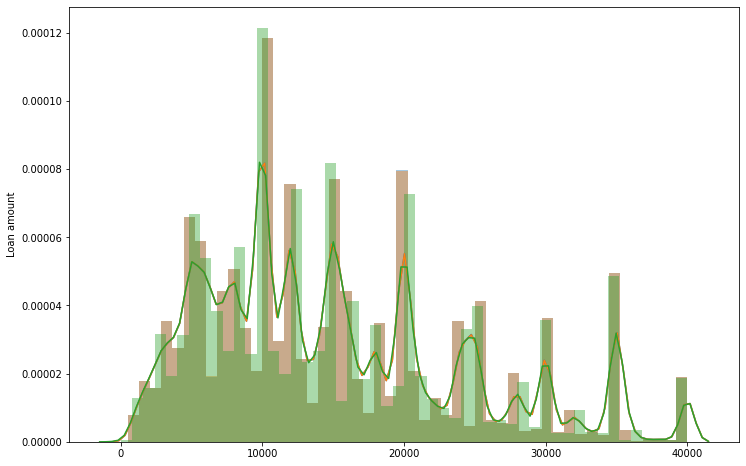

In [52]:
plt.figure(figsize=(12,8))
# Plot the distribution of loan amount applied by borrower
sns.distplot(df['loan_amnt'])
# Plot the distribution loan amount committeed
sns.distplot(df['funded_amnt'])
# Plot the distribution of loan amount committed by investors
sns.distplot(df['funded_amnt_inv'])
plt.ylabel('Loan amount')
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)

 36 months    0.71207
 60 months    0.28793
Name: term, dtype: float64


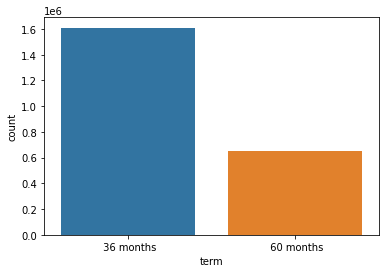

In [26]:
# Plot the term of the loans applied, in terms of percentage over all loans
print (df['term'].value_counts(normalize=True))
plt.figure(figsize=(12,8))
sns.countplot(df['term'])

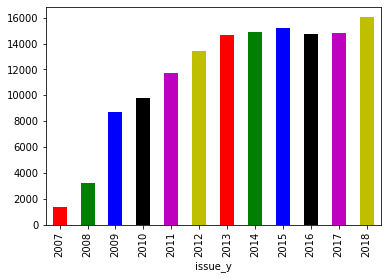

In [27]:
# Extract the year from issue_d and plot the average loan amount with respect to year
df['issue_y'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce').apply(lambda x: x.year)
df.groupby('issue_y')['funded_amnt_inv'].mean().plot(kind='bar',color=['r', 'g', 'b', 'k', 'm', 'y'])
# sns.lineplot(df.groupby('issue_y')['funded_amnt_inv'].mean().index, df.groupby('issue_y')['funded_amnt_inv'].mean().values)

### Observation
* Loan amount applied follows a multi-nomial distribution, mostly falling within 10k - 20k range
* Loan amount applied and funded follows similar distributions, this means most loans applied by eligible borrowers are approved and funded by investor 
* _71%_ of the loans applied are for _36_ months, while _29%_ are for _60_ months.
* Average loan amount increases each year, with significant jump in _2009, peak around 2015-2018_. This is probably due to financial crisis in _2008_ , which resulted in low interet rate between _2009-2018_

In [28]:
# Inspect loan status
df['loan_status'].value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

## Good Loan v.s. Bad Loan

* We categorise the loan as a bad loan if the loan status is any of the below 
* With this categorisation, we can see _13%_ of the loans are bad loans. Hence, this is a very __imbalanced dataset__, with large number of negatives if we are predicting bad loans
* However, we have to keep in mind that some of the "good" loans are still in the process of getting paid, especially loans that are more recent in this time horizon. Hence, we observe higher percentage of good loans from _2016-2018_. But these may turn bad later.

[Text(0, 0.5, '(%)')]

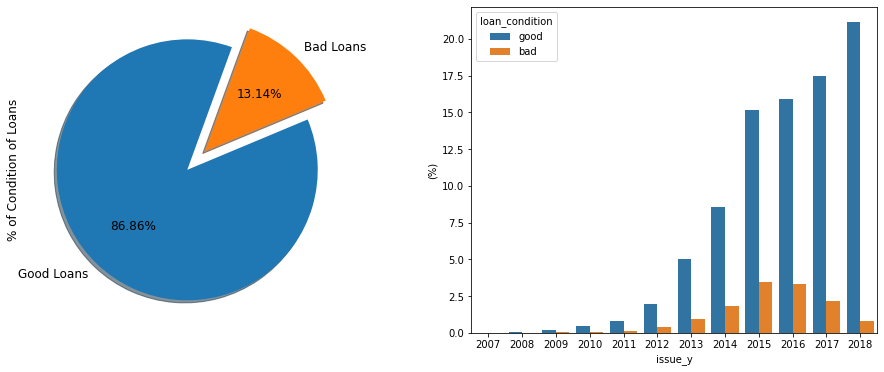

In [34]:
# We can categorise the loan as good / bad loan. 
# From the pie chart, 13% of the loans are bad loans
f, ax = plt.subplots(1,2, figsize=(16,6))
labels ="Good Loans", "Bad Loans"
bad_loan_statuses = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", \
                     "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]
df['loan_condition'] = df['loan_status'].apply(lambda x: 'bad' if x in bad_loan_statuses else 'good')
df['loan_condition'].value_counts().plot(kind='pie', explode=[0,0.2], autopct='%1.2f%%',\
                                         ax=ax[0], labels=labels, fontsize=12, startangle=70, shadow=True)
ax[0].set_ylabel('% of Condition of Loans', fontsize=12)

sns.barplot(x="issue_y", y="loan_amnt", hue="loan_condition", data=df,\
            estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")

## Plotting loans for each state

We can see that Lending clubs borrowers are most active in the few states where economy is doing well, e.g. California, Texas, New York, Florida, Illinois etc. While the states with lowest amount of loans are mostly in the Mid-West, such as North Dakota, Idaho, South Dakota etc. 

Text(0.5, 0, 'State')

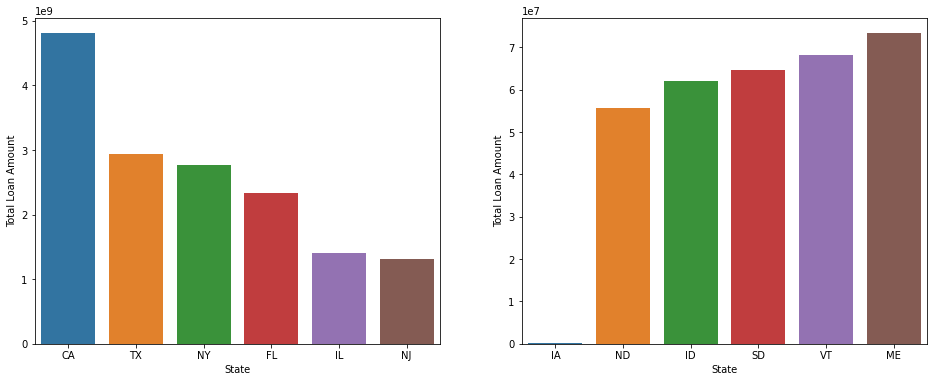

In [98]:
df['full_date'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')

# Examine which state has the highest & lowest amount of loan in total
group_date = df.groupby(['addr_state'],as_index=False)['loan_amnt'].sum()
top_6_states = group_date.sort_values('loan_amnt',ascending=False).iloc[0:6]
btm_6_states = group_date.sort_values('loan_amnt').iloc[0:6]
fig, axs = plt.subplots(1,2, figsize=(16,6))
sns.barplot(x='addr_state', y='loan_amnt',data=top_6_states, ax=axs[0])
sns.barplot(x='addr_state', y='loan_amnt',data=btm_6_states, ax=axs[1])
axs[0].set_ylabel("Total Loan Amount")
axs[0].set_xlabel("State")
axs[1].set_ylabel("Total Loan Amount")
axs[1].set_xlabel("State")

### Observation
By plotting the loan condition splits for the top 6 & bottomr 6 states, we can see that states differ in the percentage of bad loans. 
* For the top 6 states in terms of loan amount, most of them have close to the overall average (~13%) of bad loans. 
* While for the bottom 6 states, the generally have less than the average % of bad loans. This could be due to these states being more financially conservative.

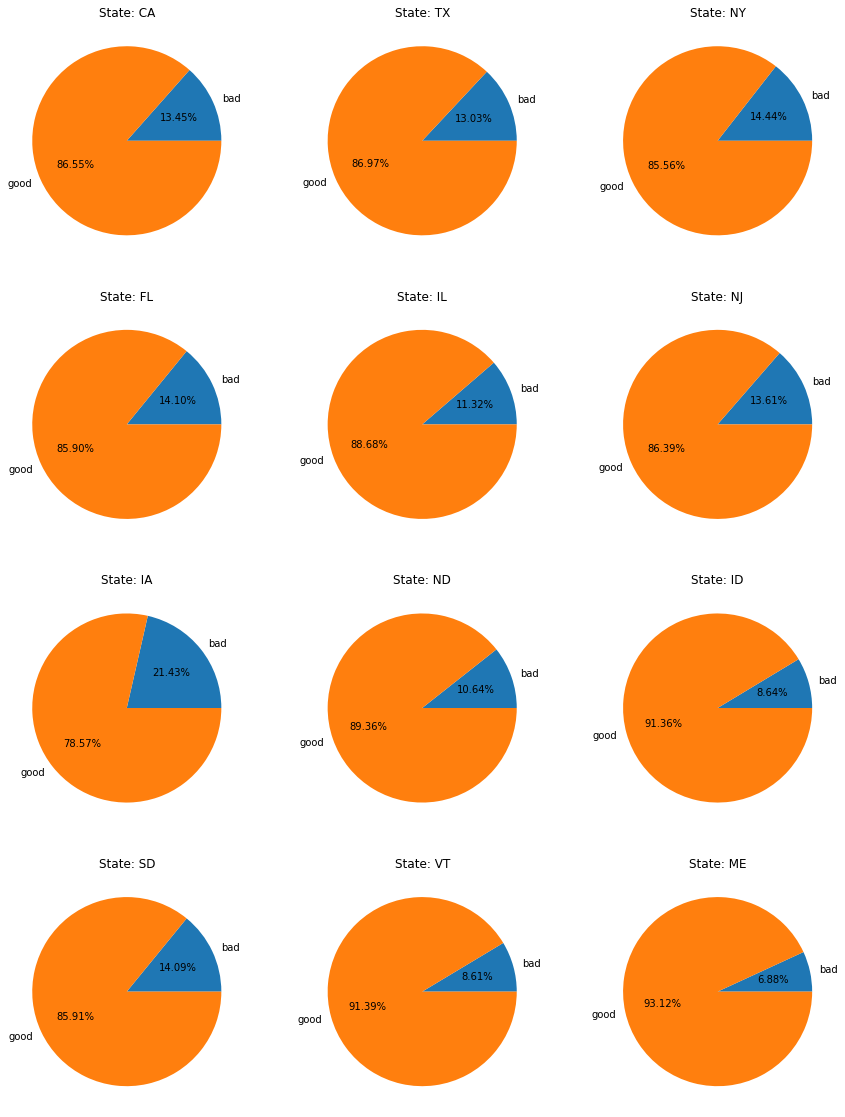

In [115]:
top_6_ls = list(top_6_states['addr_state'])
btm_6_ls = list(btm_6_states['addr_state'])
state_loan_condition = df.groupby('addr_state')['loan_condition'].value_counts(normalize=True).\
              unstack().reset_index().rename_axis(None, axis=1).set_index('addr_state')
plot_df = pd.concat([state_loan_condition.loc[top_6_ls], state_loan_condition.loc[btm_6_ls]])
# plot_df = state_loan_condition[~state_loan_condition.index.isin(['IA'])]
# print (plot_df.count())
# plot the pie good & bad loan percentage for the top 6 & bottom 6 states
fig = plt.figure(figsize=(15,20))
# print (state_loan_condition.count())
for i, (name, row) in enumerate(plot_df.iterrows()):
    ax = plt.subplot(4,3, i+1)
    ax.set_title("State: %s"%row.name)
    ax.set_aspect('equal')
    ax.pie(row, labels=row.index, autopct='%1.2f%%')